In [1]:
import torch
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset,DataLoader

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random 

In [2]:
def index_classes(items):
    idx = {}
    for i in items:
        if (i not in idx):
            idx[i] = len(idx)
    return idx

class MiniImagenet(data.Dataset):
    """
    [[Source]](https://github.com/learnables/learn2learn/blob/master/learn2learn/vision/datasets/mini_imagenet.py)
    **Description**
    The *mini*-ImageNet dataset was originally introduced by Vinyals et al., 2016.
    It consists of 60'000 colour images of sizes 84x84 pixels.
    The dataset is divided in 3 splits of 64 training, 16 validation, and 20 testing classes each containing 600 examples.
    The classes are sampled from the ImageNet dataset, and we use the splits from Ravi & Larochelle, 2017.
    **References**
    1. Vinyals et al. 2016. “Matching Networks for One Shot Learning.” NeurIPS.
    2. Ravi and Larochelle. 2017. “Optimization as a Model for Few-Shot Learning.” ICLR.
    **Arguments**
    * **root** (str) - Path to download the data.
    * **mode** (str, *optional*, default='train') - Which split to use.
        Must be 'train', 'validation', or 'test'.
    * **transform** (Transform, *optional*, default=None) - Input pre-processing.
    * **target_transform** (Transform, *optional*, default=None) - Target pre-processing.
    * **download** (bool, *optional*, default=False) - Download the dataset if it's not available.
    **Example**
    ~~~python
    ~~~
    """
    def __init__(
        self,
        root,
        mode='train',
        transform=None,
        target_transform=None):
        super(MiniImagenet, self).__init__()
        self.root = os.path.expanduser(root)
        if not os.path.exists(self.root):
            os.mkdir(self.root)
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        pickle_file = os.path.join(self.root, 'mini-imagenet-cache-' + mode + '.pkl')

        with open(pickle_file, 'rb') as f:
            self.data = pickle.load(f)

   #     self.x = torch.from_numpy(self.data["image_data"]).permute(0, 3, 1, 2).float()
        self.x =self.data["image_data"]
        self.y = np.ones(len(self.x))

        # TODO Remove index_classes from here
        self.class_idx = index_classes(self.data['class_dict'].keys())
        for class_name, idxs in self.data['class_dict'].items():
            for idx in idxs:
                self.y[idx] = self.class_idx[class_name]

    def __getitem__(self, idx):
        data = self.x[idx]
        if self.transform:
            data = self.transform(data)
        return data, self.y[idx]

    def __len__(self):
        return len(self.x)


In [3]:
import math
import torch.nn as nn
from kernel import CannyFilter,get_thin_kernels,get_gaussian_kernel

In [4]:
transform=T.Compose([T.ToTensor(),T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
transform=T.Compose([T.ToTensor()])

train_set=MiniImagenet(root="data/Mini",mode='train',transform=transform)
torch.manual_seed(0)
train_set, val_set = torch.utils.data.random_split(train_set, [30000, 8400])


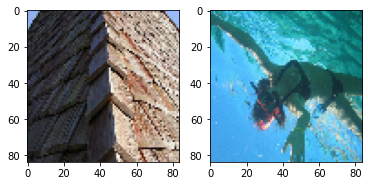

In [5]:
img1=train_set[16][0]
img2=train_set[15][0]
fig,ax=plt.subplots(1,2)
ax[0].imshow(T.ToPILImage()(img1))
ax[1].imshow(T.ToPILImage()(img2))

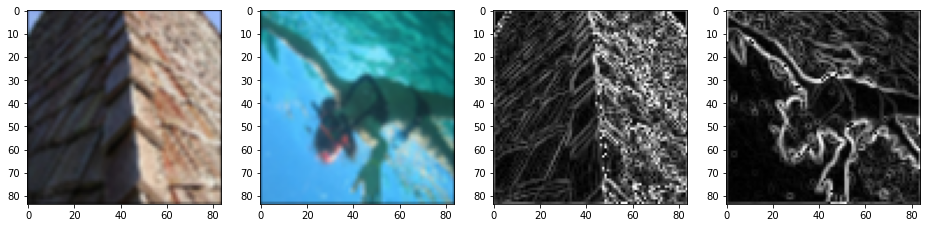

In [6]:


blur_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=True)
edge_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False)


fig,ax=plt.subplots(1,4,figsize=(16,4))
edged_img1=edge_kernel(img1.unsqueeze(0))[1][0].expand(3,-1,-1)
edged_img2=edge_kernel(img2.unsqueeze(0))[1][0].expand(3,-1,-1)
blured_img1=blur_kernel(img1.unsqueeze(0))[0]
blured_img2=blur_kernel(img2.unsqueeze(0))[0]
ax[0].imshow(T.ToPILImage()(blured_img1))
ax[1].imshow(T.ToPILImage()(blured_img2))

ax[2].imshow(T.ToPILImage()(edged_img1))
ax[3].imshow(T.ToPILImage()(edged_img2))
            

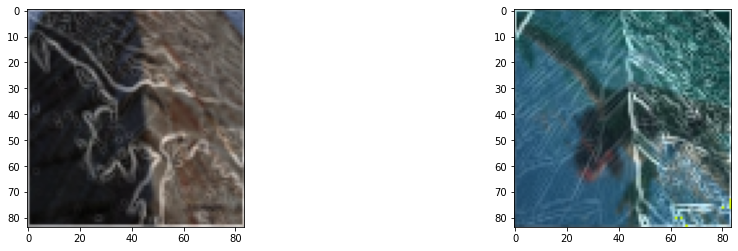

In [7]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
ax[0].imshow(T.ToPILImage()(blured_img1*0.45+edged_img2*0.45))
ax[1].imshow(T.ToPILImage()(blured_img2*0.45+edged_img1*0.45))

In [20]:
train_dl = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=32,
                                          shuffle=True,
                                          drop_last=True)
valid_dl = torch.utils.data.DataLoader(dataset=val_set,
                                          batch_size=84,
                                          shuffle=False,
                                          drop_last=True)

In [31]:
def mix_up(img,label,b_kernel,e_kernel,lamB=0.4,lamE=0.4):
    with torch.no_grad():
        blured_img=b_kernel(img)
        edged_img=e_kernel(img)[1].expand(-1,3,-1,-1)
    idx = torch.randperm(blured_img.shape[0])
    edged_img=edged_img[idx]
    y_b,y_e=label,label[idx]
    mixed_img=lamB*blured_img+lamE*edged_img#+0.2*img

    return mixed_img,y_b,y_e
def mixup_criterion(criterion, pred, y_a, y_b, lamB=0.4,lamE=0.4):
    return lamB * criterion(pred, y_a) + (1 - lamE) * criterion(pred, y_b)

In [23]:
device="cuda"

In [ ]:
import wandb

In [15]:
img,label=next(iter(train_dl))
blur_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=True)
edge_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False)
blured_img=blur_kernel(img)
#plt.figure()
#plt.imshow(T.ToPILImage()(blured_img[0]))
edged_img=edge_kernel(img)[1].expand(-1,3,-1,-1)
idx = torch.randperm(blured_img.shape[0])
img=img[idx]
blured_img=blured_img[idx]
#plt.figure()
#plt.imshow(T.ToPILImage()(blured_img[0]))
y_a,y_b=label,label[idx]
mixed_img=0.45*blured_img+0.45*edged_img#+0.2*img

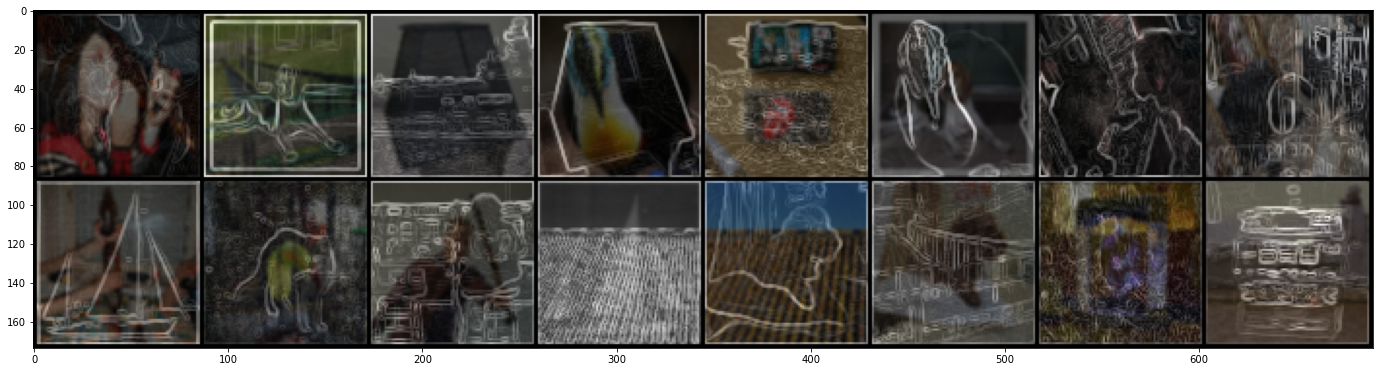

In [13]:
import torchvision
grid_img = torchvision.utils.make_grid(mixed_img[0:16], nrow=8,normalize=True)

#gt=[label_name[x.long()] for x in LABELS]
plt.figure(figsize=(24,16))
#plt.title(gt)
plt.imshow(grid_img.permute(1, 2, 0))

In [26]:
import torchvision.models as models
model = models.resnet18(num_classes=64)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,
                      weight_decay=1e-4)

In [34]:
blur_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=True,use_cuda=True)
blur_kernel.to(device)
edge_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False,use_cuda=True)
edge_kernel.to(device)

model.to(device)

wandb.init(project="Augmentation_Strategy")
wandb.run.name = "MixFreq"
wandb.run.save()
max_val_accuracy=0
for epoch in tqdm(range(30)):
    print(f'Epochs : {epoch+1}')
    model.train()
    avg_train_loss=0
    correct=0
    total=0
    for batch_idx,(img,label) in enumerate(train_dl):
        #Zero_grad_Optimizer
        optimizer.zero_grad()
        img=img.to(device)
        label=label.to(device).long()

        img,labelA,labelB=mix_up(img,label,blur_kernel,edge_kernel)
        output=model(img)
        loss=mixup_criterion(criterion,output,labelA,labelB)
        #Measure Loss
        loss=mixup_criterion(criterion,output,labelA,labelB)
        loss.backward()

        #Update Parameters
        optimizer.step()
        avg_train_loss+=loss.item()
        if batch_idx % 50==0:
            wandb.log({
                "Train Loss": avg_train_loss/(batch_idx+1)})
    model.eval()
    valid_loss=0
    correct=0
    total=0

    for batch_idx,(img,label) in enumerate(valid_dl):

        img=img.to(device)
        label=label.to(device).long()

        output=model(img)
        #Measure Loss
        loss=criterion(output,label)
        valid_loss+=loss.item()

        _, predicted = torch.max(output.data, 1)
        total+=label.size()[0]
        correct += (predicted == label).sum().item()
    avg_valid_loss=valid_loss/(len(valid_dl))
    wandb.log({
        "epoch": epoch,
        "Val Accuracy": correct/total,
        "Val Loss": avg_valid_loss})
    if (correct/total)>max_val_accuracy:
        max_val_accuracy=correct/total
        print('Validation Result is better, saving the new model')
        torch.save(model.state_dict(),"mix_freq.h")


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]


In [14]:
mixed_img.shape

torch.Size([32, 3, 84, 84])

In [16]:
y_a

tensor([45., 39., 10.,  0., 19., 49., 21., 44.,  1., 21.,  4., 47., 58.,  1.,
        27.,  5., 22., 18., 30., 56., 10., 55., 13., 27., 46., 57., 13., 55.,
        41., 47., 14., 22.], dtype=torch.float64)

In [17]:
y_b

tensor([22., 27., 46., 10., 41., 27., 22., 55.,  0., 57.,  5., 55.,  4., 21.,
        47., 45., 39., 44., 21., 10., 56., 19.,  1., 47., 49., 14., 18., 58.,
        13.,  1., 30., 13.], dtype=torch.float64)